# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm

In [12]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [70]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


### Question 1
The appropriate test for this problem would be a test for a difference in proportion between two groups. What we want to know is whether the probability of receiving a callback is different between black vs. white individuals. The central limit theorem applies in this instance if the sampling distributions for the proportions in both populations are approximately normal. This will occur if np>=10 and n(p-1)>=10. Because these terms refer to the number of individuals that are in each of our relevant cells (w/b X callback/no callback), we can grab those values from our dataset to see if CLT applies:  

In [20]:
#Group data by race and call, count instances in each
data.groupby(['race','call']).count().id

race  call
b     0.0     2278
      1.0      157
w     0.0     2200
      1.0      235
Name: id, dtype: int64

Because there are more than 10 observations in each cell (the lowest being 157), we can safely assume a normal sampling distribution and apply the CLT.

### Question 2
The null hypothesis for this test is that the there is no difference in the proportion of callbacks received by black vs. white individuals. The alternate hypothesis is that probability of receiving a callback differs for black vs. white individuals.

### Question 3
#### Bootstrap method
We will first test for a difference in proportions using a bootstrap approach. Because our null hypothesis is that there is no group difference, we will create permutation samples that ignore race, and then generate the relevant permutation replicates, which are the differences in proportion between each pair of samples. We will then calculate what proportion of these replicates have a value that is at least as large as the observed difference in our data. To generate the confidence interval and determine whether we should reject our null hypothesis, we will use an alpha of 0.05:


Observed difference in group proportions:  0.032032854209445585
95% Confidence interval:  [-0.02710472 -0.01806982]
p-value: 0.0


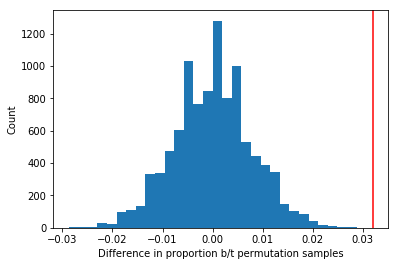

In [59]:
#Set alpha, num reps, and seed
alpha = 0.05
n_reps = 10000
np.random.seed(42)

#Function for calculating difference in proportion
def diff_prop(data_A, data_B):
    prop_A = np.sum(data_A) / len(data_A)
    prop_B = np.sum(data_B) / len(data_B)
    return prop_B - prop_A

#Function for generating permutation sample for two groups
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data, )

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

#Function for generating permutation replicates
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

#Grab callback data for black names and white names
b_call = data[data.race=='b'].call
w_call = data[data.race=='w'].call

#Calculate observed difference in proportion of callbacks between groups
diff_prop_obs = diff_prop(b_call, w_call)

#Generate permutation replicates for diff in proportions
perm_reps = draw_perm_reps(b_call, w_call, diff_prop, size=n_reps)

#Calculate confidence interval for p=0.05
CI = np.percentile(perm_reps, [alpha/2, 1-(alpha/2)])

#Calculate p-value for observed difference in proportion
p_value = np.sum(perm_reps >= diff_prop_obs) / n_reps

#plot histogram of sampling distrubtion
_ = plt.hist(perm_reps, bins=30)
_ = plt.xlabel("Difference in proportion b/t permutation samples")
_ = plt.ylabel("Count")
_ = plt.axvline(x=diff_prop_obs, color='red')

print("Observed difference in group proportions: ", diff_prop_obs)
print("95% Confidence interval: ", CI)
print("p-value:", p_value)


Our observed difference (indicated by the red line in the plot) is well outside of our confidence interval range. Our p-value is also indistinguishable from zero, indicating that not a single replicate out of 10,000 had a value as extreme as the observed difference. This leads us to reject the null hypothesis and conclude that race does make a difference in callback probability.

We can also construct a confidence interval for the actual difference in proportions by creating bootstrap samples for each group separately, then calculating the difference in proportion for each pair of samples: 

In [66]:
#Define bootstrap replicate function
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

#Define draw_bs_reps function
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

w_bs = draw_bs_reps(w_call, np.mean, size=10000)
b_bs = draw_bs_reps(b_call, np.mean, size=10000)

diff_dist = w_bs - b_bs

CI_new = np.percentile(diff_dist, [2.5, 97.5])
print("Confidence interval for difference in population proportions: ", CI_new)

Confidence interval for difference in population proportions:  [0.01683778 0.04722792]


Because this interval does not include 0, we can also conclude from this approach that race is a factor in the likelihood of receiving a callback.

#### Frequentist method
Under the frequentist method, we will test our hypothesis by first calculating a z-statistic that corresponds to sampling distribution of differences in proportion. The numerator will be the observed difference in proportion, and the denominator will be the standard deviation of the the sampling distribution of differences:

In [67]:
#Calculate combined proportion for estimating std error
comb_prop = (sum(b_call) + sum(w_call)) / len(data)

#Calculate estimate for variance of sampling distribution and take sqrt to get std error
std_error = np.sqrt(comb_prop*(1-comb_prop)/len(b_call) + comb_prop*(1-comb_prop)/len(w_call))

#Calculate z-score
z = diff_prop_obs / std_error

#Calculate p-value from z-score under normal distribution
p_value_f = 1 - norm.cdf(z)
print("p-value: ", p_value_f)

#Calculate margin of error for 95% CI
ME_f = norm.ppf(1-(alpha/2)) * std_error
print("Margin of error: +-", ME_f)

#Calculate 95% CI
CI_f = [diff_prop_obs - ME_f, diff_prop_obs + ME_f]
print("95% Confidence Interval: ", CI_f)

p-value:  1.991943418788722e-05
Margin of error: +- 0.015281631502169232
95% Confidence Interval:  [0.01675122270727635, 0.04731448571161482]


Using the frequentist method, we obtain an answer that is very similar to the bootstrap approach. The p-value indicates that there is very small probability of obtaining a difference of proportions as large as we did by chance. The confidence interval also is very similar to the one obtained through bootstrapping.

### Questions 4 and 5

Looking at the p-values above, we can reasonably conclude that race is a statistically significant factor in the likelihood of receiving a job callback. The 95% confidence interval ranges from roughly 0.017 to 0.047, meaning that there is likely between a 1.7% and 4.7% increase in the chance of receiving a callback if you have a white-sounding name compared to a black-sounding name. Though this may appear to be a relatively small advantage, for many people who are on the threshold of being considered for a job, it may prove to be decisive. 

However, it also indicates that race is in no way decisive for all individuals. After all, individuals with white-sounding names only received callbacks in approximately 9.6% of cases (compared to 6.4% of those with black-sounding names). This suggests that there are other factors that may be even more important in determining who gets a call. To test this idea, we could run similar analyses with other variables in our dataset. For instance, education and years of experience would appear to be good candidates, as would the type of industry in which the individual has been employed.